In [1]:
# import libraries
import os, sys, glob, pickle, tables

import numpy as np
import matplotlib.pyplot as plt

from pandas import DataFrame

# pip install simweights <--- run this once to install the package
# then replace <username> with your username and <version> with your Python version
sys.path.append('/home/tfutrell/.local/lib/python3.12/site-packages')
import simweights

In [2]:
# Paths to h5 files
PATHS = ['/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/p/12360_v1s/h5files/*.h5',
'/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/He/12630_v1s/h5files/*.h5',
'/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/O/12631_v1s/h5files/*.h5',
'/data/ana/CosmicRay/IceTop_level3/sim/IC86.2012/SIBYLL2.1/Fe/12362_v1s/h5files/*.h5']

In [3]:
# Define important functions
def weighting(path):
    weighter = None
    filelist = glob.glob(path)

    for filename in filelist:
        file_obj = tables.open_file(filename, 'r')
    
        if weighter is None:
            weighter = simweights.IceTopWeighter(file_obj)
        else:
            weighter += simweights.IceTopWeighter(file_obj)
    return weighter

def weighted_quantiles(values, weights, quantiles=0.5):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, np.array(quantiles) * c[-1])]]

def weighted_percentile(data, weights, percentile):
    """
    Compute the weighted percentile of a dataset.
    
    Parameters:
    - data: array-like, the data values.
    - weights: array-like, same length as data.
    - percentile: float between 0 and 100.
    
    Returns:
    - The weighted percentile value.
    """
    data = np.asarray(data)
    weights = np.asarray(weights)
    
    # Sort data and weights by data
    sorted_indices = np.argsort(data)
    data_sorted = data[sorted_indices]
    weights_sorted = weights[sorted_indices]

    # Compute the cumulative sum of weights
    cumulative_weights = np.cumsum(weights_sorted)
    normalized_weights = cumulative_weights / cumulative_weights[-1]  # normalize to 1

    # Find where the normalized cumulative weight exceeds the desired percentile
    return np.interp(percentile / 100, normalized_weights, data_sorted) 

In [4]:
# Load in the SIBYLL2.1 particle sims
weighter = None

if os.path.isfile('pickles/energy.pkl'):
    with open('pickles/energy.pkl', 'rb') as file:
        primary_energy = pickle.load(file)
else:
    for path in PATHS:
        if weighter == None:
            weighter = weighting(path)
        else:
            weighter += weighting(path)

if os.path.isfile('pickles/hits.pkl'):
    with open('pickles/hits.pkl', 'rb') as file:
        hits = pickle.load(file)
elif not weighter==None:
    for path in PATHS:
        if weighter == None:
            weighter = weighting(path)
        else:
            weighter += weighting(path)

if os.path.isfile('pickles/particle_type.pkl'):
    with open('pickles/particle_type.pkl', 'rb') as file:
        particle_type = pickle.load(file)
elif not weighter==None:
    for path in PATHS:
        if weighter == None:
            weighter = weighting(path)
        else:
            weighter += weighting(path)

if os.path.isfile('pickles/reco_pass.pkl'):
    with open('pickles/reco_pass.pkl', 'rb') as file:
        reco_pass = pickle.load(file)
elif not weighter==None:
    for path in PATHS:
        if weighter == None:
            weighter = weighting(path)
        else:
            weighter += weighting(path)

if os.path.isfile('pickles/Hweights.pkl'):
    with open('pickles/Hweights.pkl', 'rb') as file:
        Hweights = pickle.load(file)
elif not weighter==None:
    for path in PATHS:
        if weighter == None:
            weighter = weighting(path)
        else:
            weighter += weighting(path)
                
if os.path.isfile('pickles/Gweights.pkl'):
    with open('pickles/Gweights.pkl', 'rb') as file:
        Gweights = pickle.load(file)
elif not weighter==None:
    for path in PATHS:
        if weighter == None:
            weighter = weighting(path)
        else:
            weighter += weighting(path)

In [5]:
# Define quality cuts
# quality_cut = max_inside * station_density_pass * standard_filter * reco_pass * neighbour_max_signal_4 * max_signal_6 * laputop_frac * beta_cut
# quality_cut = quality_cut.astype(bool)

In [6]:
# If there are missing pkl files, load them with weighter
if not os.path.isfile('pickles/energy.pkl'):
    primary_energy = weighter.get_column('MCPrimary', 'energy')

if not os.path.isfile('pickles/particle_type.pkl'):
    particle_type = weighter.get_column('MCPrimary', 'type')
    
if not os.path.isfile('pickles/hits.pkl'):
    hits = weighter.get_column('IceTopHLCSeedRTPulses_SnowUnAttenuated_info', 'nstrings')
    
if not os.path.isfile('pickles/Hweights.pkl'):
    # (p, He, N, Al, Fe) version of this model.
    fluxH = simweights.GaisserH4a_IT()

    # Get the weights by passing the flux to the weighter
    Hweights = weighter.get_weights(fluxH)

In [7]:
# Dictionary set-ups
CUTS = {
    'proton': particle_type==2.21200000e+03,
    'helium' : particle_type==1.00002004e+09,
    'oxygen': particle_type==1.00008016e+09,
    'iron': particle_type==1.00026056e+09,
    'true': np.tile(True, len(primary_energy))
}
A = {
    'proton': 1.0073,
    'helium': 4.0026,
    'oxygen': 16,
    'iron': 55.845  
}
Z = {
    'proton': 1,
    'helium': 2,
    'oxygen': 8,
    'iron': 26  
}
'''
Tier 1: 2011-14 is 3≤n<5
Tier 2: 2011 is 5≤n<10; 2012-2013 is 5≤n<9; 2014 is 5≤n<8
Tier 3: 2011 is 10≤n<14, from 2012-13 9≤n<16; 2014-15 is 8≤n<15; 
Tier 4: 2011 is 14≤n, 2012-13 16≤n; 2014-15 is 15≤n; 2016-17 is 14≤n; 2018-19 is 13≤n; 2020-21 is 12≤n
'''
TIERS = {
    'Tier 3': (8<=hits)*(hits<15),
    'Tier 4': 15<=hits
}
COLORS = {
    'true' : 'black',
    'proton': 'red',
    'helium': 'orange',
    'oxygen': 'purple',
    'iron': 'blue'
}
LABEL = {
    'true' : 'Data',
    'proton': 'P',
    'helium': 'He',
    'oxygen': 'O',
    'iron': 'Fe'
}
SIMS = {
    'H4a': Hweights,
    'GSF': Gweights
}
WEIGHTS = {
    'true'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'proton': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'helium': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'oxygen': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'iron'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},}
}
BINS = {
    'true'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'proton': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'helium': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'oxygen': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'iron'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},}
}
LINESTYLE = {
    'H4a': None,
    'GSF': '--'
}
TABLE = {
        'H4a': {'Tier 3': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0},
                'Tier 4': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0}},
        'GSF': {'Tier 3': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0},
                'Tier 4': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0}}
    }

Tier 3

H4a
    proton
        Median: 2.22 PeV
        68%: 1.26-4.29 PeV

    iron
        Median: 3.66 PeV
        68%: 1.96-8.23 PeV

    true
        Median: 2.75 PeV
        68%: 1.49-5.57 PeV

GSF
    proton
        Median: 2.34 PeV
        68%: 1.34-4.29 PeV

    iron
        Median: 3.28 PeV
        68%: 1.79-8.23 PeV

    true
        Median: 2.67 PeV
        68%: 1.46-5.57 PeV

Tier 4

H4a
    proton
        Median: 7.18 PeV
        68%: 4.23-15.7 PeV

    iron
        Median: 11.46 PeV
        68%: 5.87-27.75 PeV

    true
        Median: 8.6 PeV
        68%: 4.87-19.71 PeV

GSF
    proton
        Median: 7.39 PeV
        68%: 4.32-15.7 PeV

    iron
        Median: 11.07 PeV
        68%: 5.65-27.75 PeV

    true
        Median: 8.32 PeV
        68%: 4.73-19.71 PeV



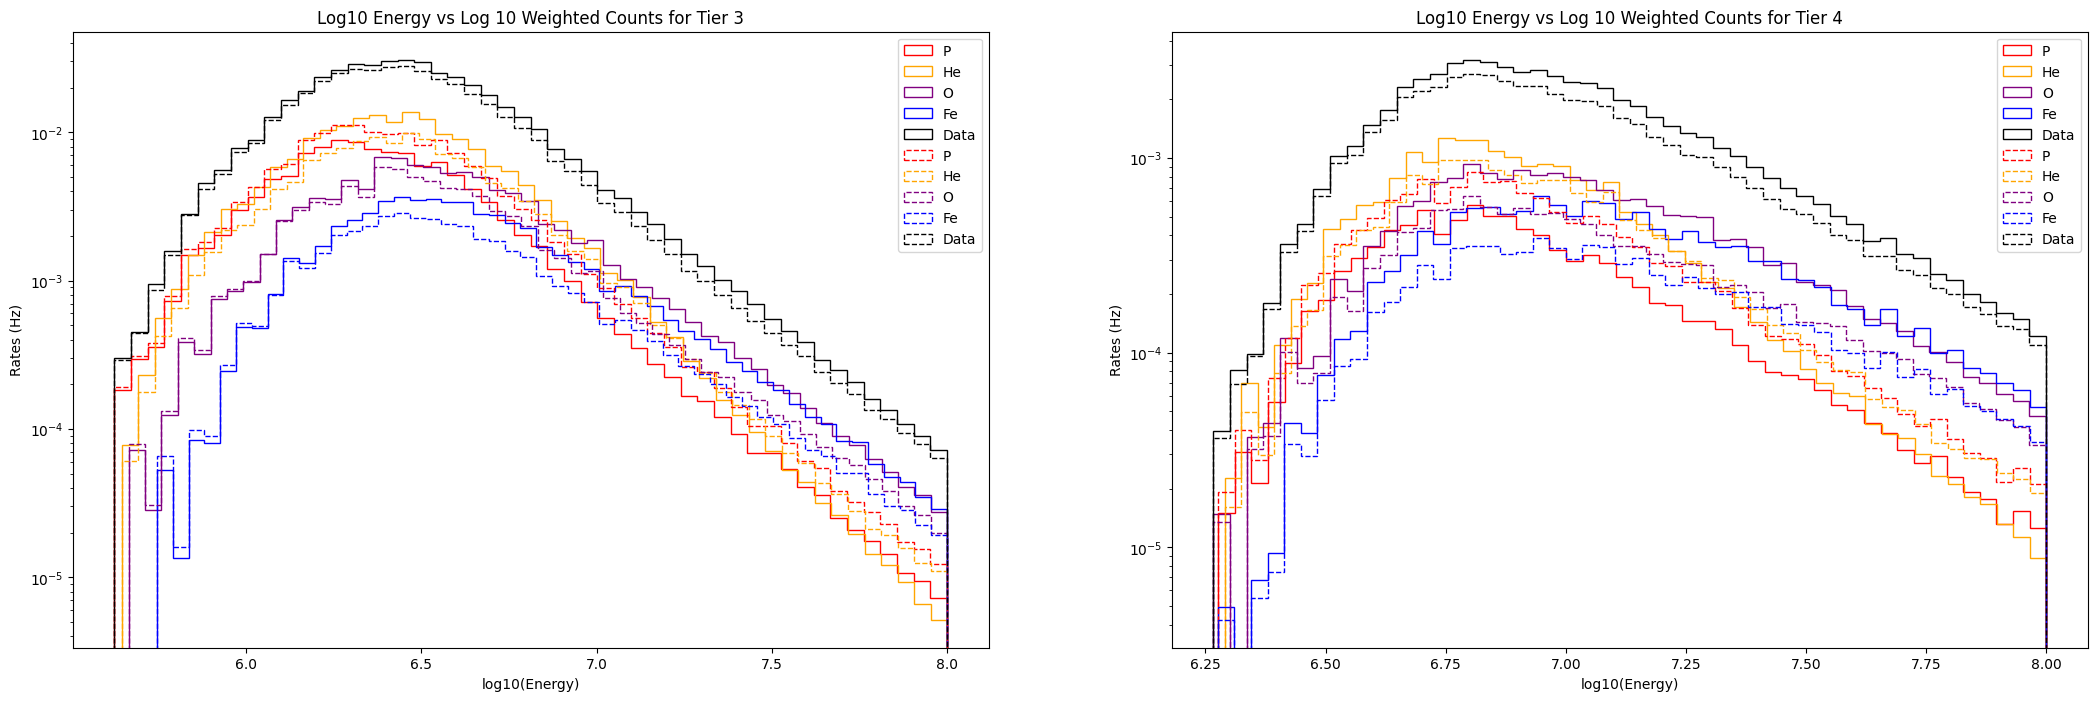

In [8]:
# Graph Log10 Energy vs Log 10 weighted counts
ncols = len(TIERS)

fig, axs = plt.subplots(figsize = (13 * ncols, 8), ncols=ncols)

for tier, tier_cut, ax in zip(TIERS.keys(), TIERS.values(), axs):
    print(tier)
    print()
    
    for weight_name, weights in SIMS.items():
        print(weight_name)

        for comp, comp_cut in CUTS.items():
            combined_cut = comp_cut * tier_cut
            WEIGHTS[comp][tier][weight_name], BINS[comp][tier][weight_name], patches1 = ax.hist(np.log10(primary_energy[combined_cut]), bins=50, weights=weights[combined_cut], linestyle=LINESTYLE[weight_name], log=True, label = LABEL[comp], histtype='step', color=COLORS[comp])
        
            if comp=='proton' or comp=='iron' or comp=='true':
                print(f'    {comp}')
                print(f'        Median: {round(weighted_quantiles(primary_energy[comp_cut * tier_cut]/1000000, weights[comp_cut * tier_cut]), 2)} PeV')
                print(f'        68%: {round(weighted_percentile(primary_energy[comp_cut * tier_cut]/1000000, weights[comp_cut * tier_cut], 16), 2)}-{round(weighted_percentile(primary_energy[combined_cut]/1000000, Hweights[combined_cut], 84), 2)} PeV')
                print()

    ax.set_xlabel('log10(Energy)')
    ax.set_ylabel('Rates (Hz)')
    ax.set_title(f'Log10 Energy vs Log 10 Weighted Counts for {tier}')
    ax.legend()

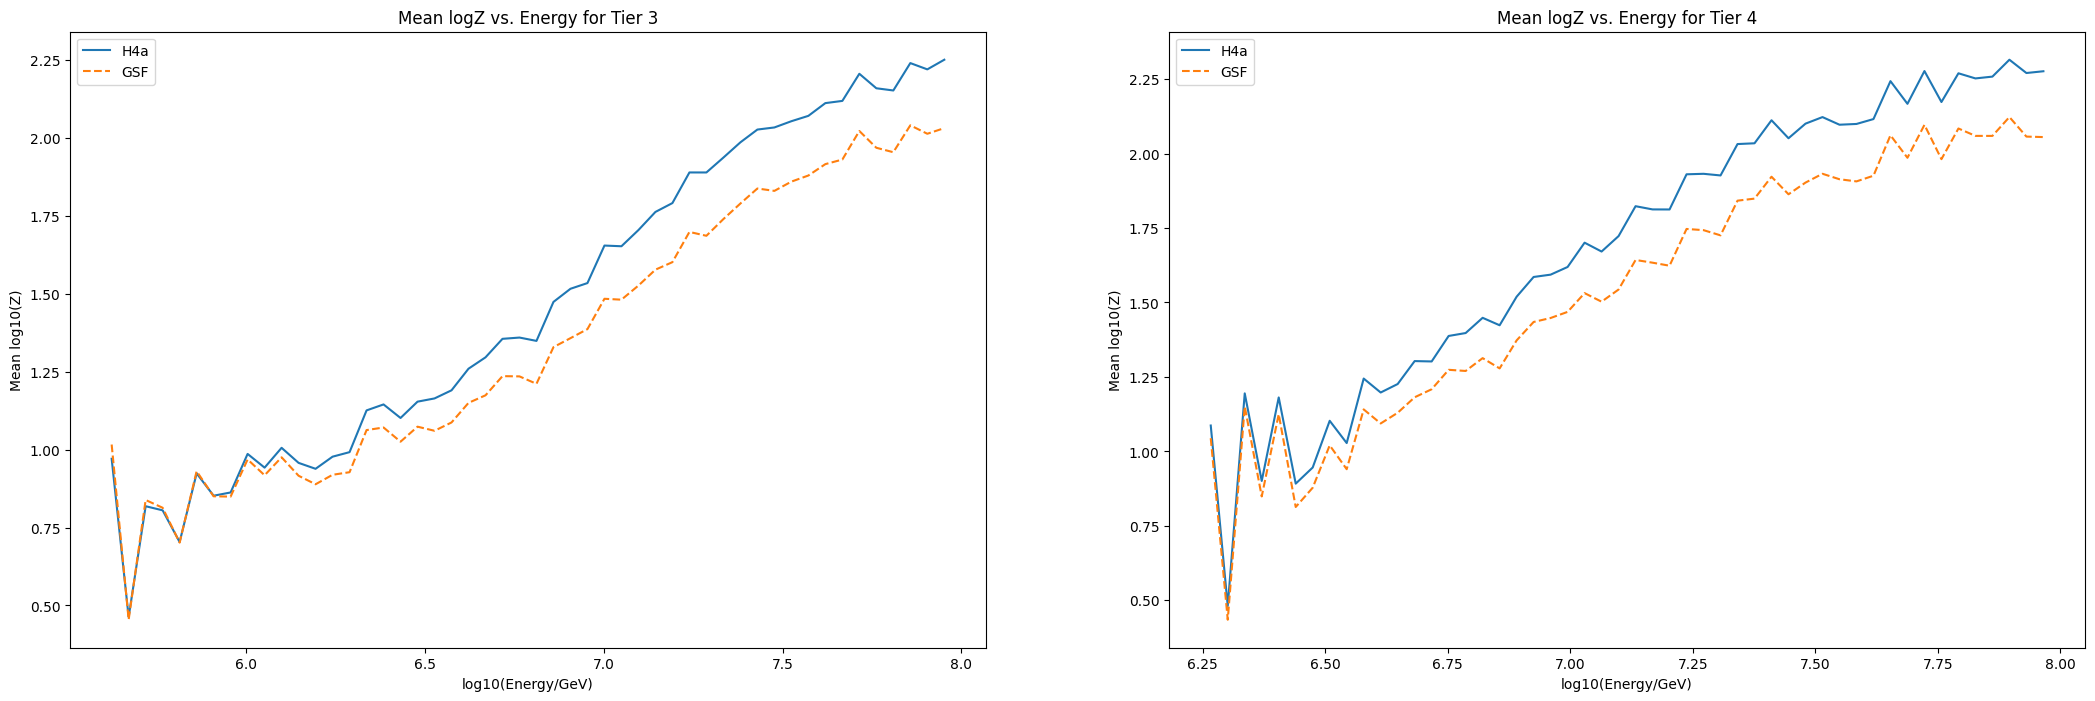

In [9]:
# Mean Atomic Charge
TOTALS = {
    'Tier 3': {'H4a': 0, 'GSF': 0},
    'Tier 4': {'H4a': 0, 'GSF': 0}
}

fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)

for tier, tier_cut, ax in zip(TIERS.keys(), TIERS.values(), axs):
    totZ = 0
    totH = 0
    for weight_name, weights in SIMS.items():    
        for comp, comp_cut in CUTS.items():
            if not comp=='true':
                totZ += WEIGHTS[comp][tier][weight_name] * np.log(Z[comp])
                totH += WEIGHTS[comp][tier][weight_name]
        
        TOTALS[tier][weight_name] = totH
        meanZ = totZ / totH

        ax.plot(BINS['true'][tier][weight_name][:-1], meanZ, label=weight_name, linestyle=LINESTYLE[weight_name])

    ax.set_xlabel('log10(Energy/GeV)')
    ax.set_ylabel('Mean log10(Z)')
    ax.set_title(f'Mean logZ vs. Energy for {tier}')

    ax.legend()

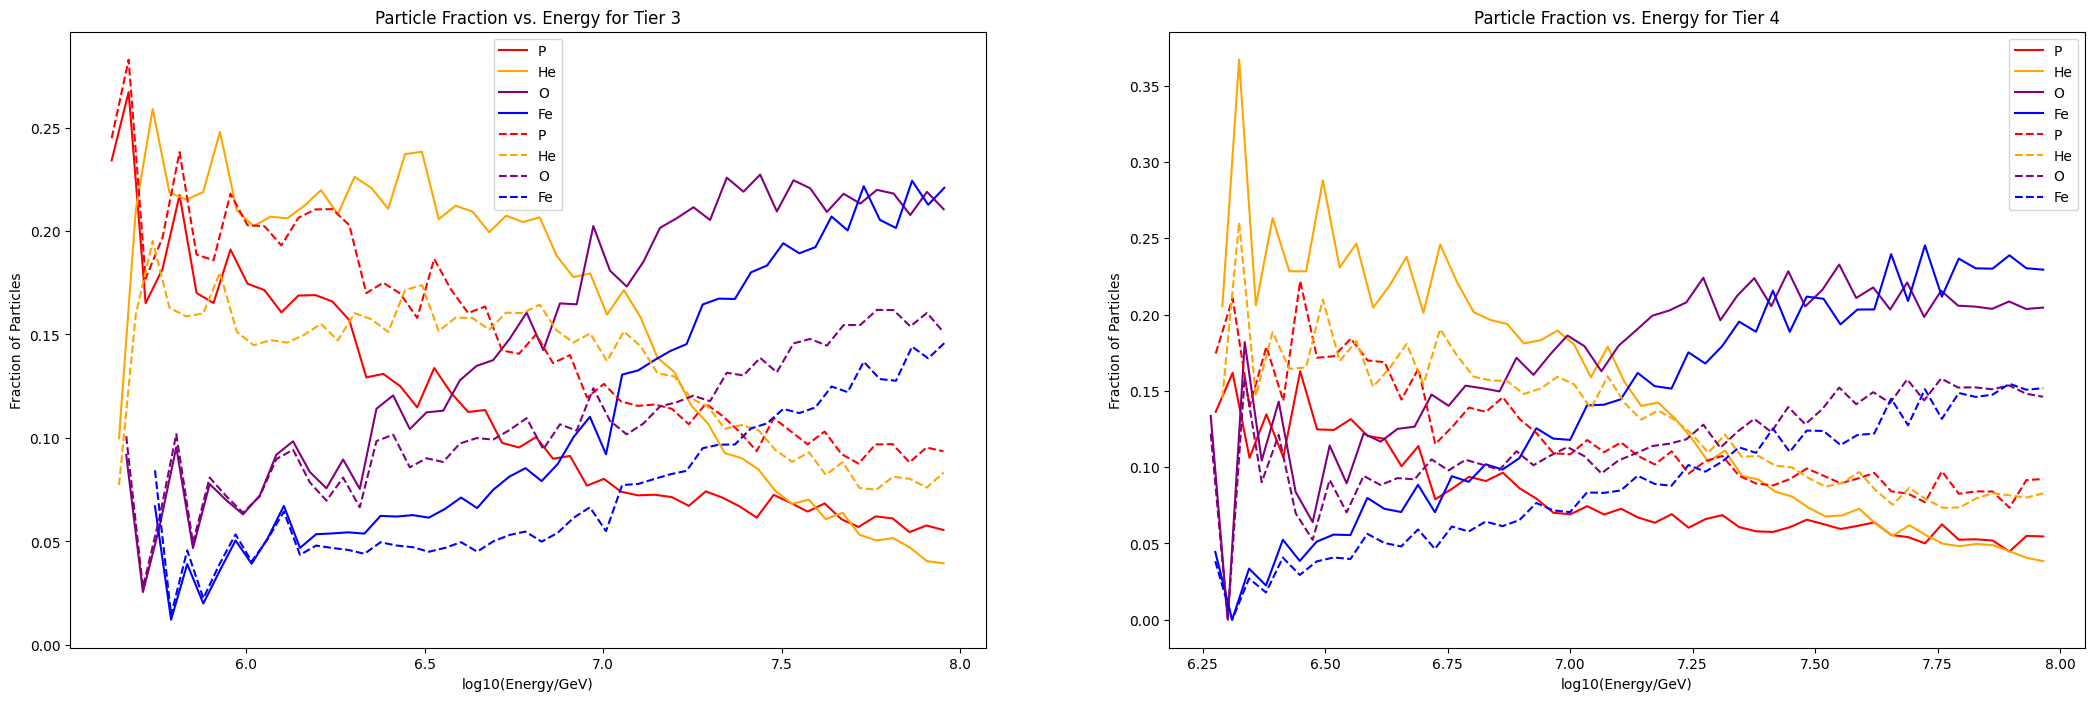

In [10]:
# Particle Fraction vs. Energy
fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)

for tier, tier_cut, ax in zip(TIERS.keys(), TIERS.values(), axs):
    for weight_name, weights in SIMS.items():
        for comp in CUTS:
            if not comp=='true':
                ax.plot(BINS[comp][tier][weight_name][:-1], WEIGHTS[comp][tier][weight_name] / TOTALS[tier][weight_name], label=LABEL[comp], linestyle=LINESTYLE[weight_name], color=COLORS[comp])

    ax.set_xlabel('log10(Energy/GeV)')
    ax.set_ylabel('Fraction of Particles')
    ax.set_title(f'Particle Fraction vs. Energy for {tier}')

    ax.legend()

In [13]:
# Table of the overall percentage of particles, ln(A), and mean log of rigidity
for weight_name, weights in SIMS.items():
    print(weight_name)
    print()

    for tier, tier_cut in TIERS.items():
        mean_A = 0
        summation = 0
        denominator = 0
        
        for comp, comp_cut in CUTS.items():
            if not comp=='true':
                combined_cut = comp_cut * tier_cut
                    
                TABLE[weight_name][tier][f'{comp} part'] = round(len(primary_energy[combined_cut]) / len(primary_energy[tier_cut]), 3)
                
                mean_A += TABLE[weight_name][tier][f'{comp} part'] * np.log(A[comp])
                
                summation += np.sum(10**WEIGHTS[comp][tier][weight_name]) * Z[comp]
                denominator += np.sum(10**WEIGHTS[comp][tier][weight_name])

        TABLE[weight_name][tier]['<log(R)>'] = round(weighted_quantiles(np.log10(primary_energy)[tier_cut] - 3, weights[tier_cut]) - np.log10(summation/denominator), 3)
        TABLE[weight_name][tier]['ln(A)'] = round(mean_A, 3)

    print(DataFrame(TABLE[weight_name]))
    print()

H4a

             Tier 3  Tier 4
proton part   0.261   0.240
helium part   0.260   0.266
oxygen part   0.246   0.247
iron part     0.233   0.246
ln(A)         1.982   2.045
<log(R)>      2.474   2.968

GSF

             Tier 3  Tier 4
proton part   0.261   0.240
helium part   0.260   0.266
oxygen part   0.246   0.247
iron part     0.233   0.246
ln(A)         1.982   2.045
<log(R)>      2.462   2.954



In [12]:
fluxG = simweights.GlobalSplineFit_IT()

print(fluxG.pdgids)
print(fluxG.groups)

(<PDGCode.PPlus: 2212>, <PDGCode.He4Nucleus: 1000020040>, <PDGCode.O16Nucleus: 1000080160>, <PDGCode.Fe56Nucleus: 1000260560>)
((1, 1), (2, 2), (3, 10), (11, 28))
